In [1]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from dask.distributed import Client, LocalCluster
from yahist import Hist1D, Hist2D

from condor_utils import make_htcondor_cluster

In [136]:
from utils import get_results, clear_tree_cache, plot_timeflow

In [3]:
cluster = make_htcondor_cluster(dashboard_address=12347)
cluster.scale(16)
cluster

In [162]:
client = Client(cluster)
client

Client Scheduler: tcp://169.228.130.74:23365 Dashboard: http://169.228.130.74:12347/status,Cluster Workers: 30 Cores: 30 Memory: 120.00 GB


In [163]:
fnames = glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DoubleEG_Run201*x3/*.root")
print(len(fnames))

155


In [164]:
# Takes in a dataframe-like object based on a chunk of a file
# must return a dictionary of things that can be added with `+`
def process(df):
    out = dict()
    out["mycounter"] = len(df)
    out["hmet"] = Hist1D(df["MET_pt"], bins="200,0,1000", label="MET_pt")
    return out

In [165]:
results = get_results(process, fnames, use_tree_cache=True, chunksize=500e3)

Making chunks for workers
Processing 457 chunks



Processed 1.9055e+08 input events in 75.5s (2525.44kHz)


In [166]:
# use_tree_cache speeds things up the second time you run on the same files (if you're looping on <200 files)
# so we run it again. In principle, `process` can be changed and we'll still see a speedup due to the
# overhead of opening up a nanoaod ttree with uproot
results = get_results(process, fnames, use_tree_cache=True, chunksize=500e3)

Making chunks for workers
Processing 457 chunks



Processed 1.9055e+08 input events in 4.1s (46317.96kHz)


/home/users/namin/miniconda3/envs/nanoanalysisenv/lib/python3.7/site-packages/yahist/utils.py:1: RuntimeWarning: overflow encountered in exp
  from __future__ import print_function


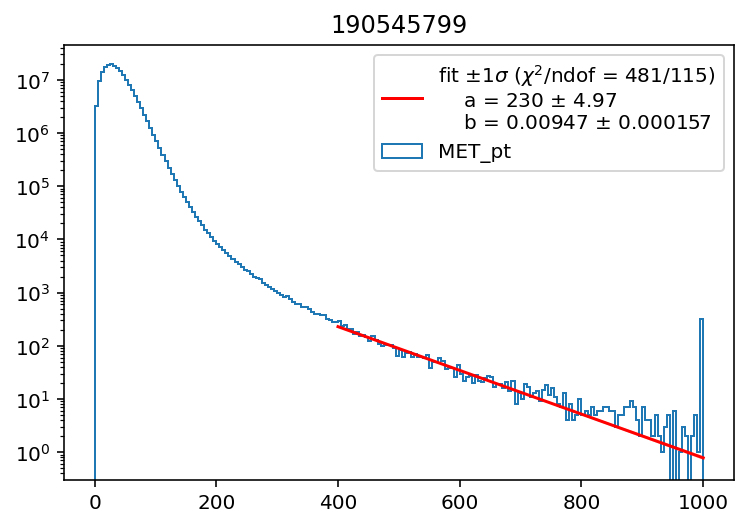

In [167]:
fig, ax = plt.subplots()

h = results["hmet"]

h.plot(histtype="step")
h.restrict(400, 1e6).fit("a*np.exp(-b*(x-400))")

ax.set_title(str(results["mycounter"]))
ax.set_yscale("log")

In [168]:
plot_timeflow(results)

Loading BokehJS ...

In [169]:
[v["metrics"]["numtreescached"] for v in client._scheduler_identity["workers"].values()]

[12,
 12,
 12,
 14,
 10,
 10,
 3,
 15,
 16,
 18,
 15,
 12,
 13,
 13,
 13,
 15,
 16,
 15,
 16,
 16,
 18,
 22,
 21,
 20,
 15,
 23,
 14,
 14,
 22,
 19]